Consider a high dim dataset.  
Perform dimensionality reduction using t-SNE, LLE, UMAP, and ISOmap to reduce the data to 2D.   
Visualize the resulting 2D embeddings from each method.

In [6]:
from sklearn.datasets import load_iris
import numpy as np

# Load the Iris dataset
iris = load_iris()
X = iris.data

print("Shape of the loaded dataset:", X.shape)

Shape of the loaded dataset: (150, 4)


In [7]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
import umap

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Apply LLE
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_lle = lle.fit_transform(X)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Apply Isomap
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X)

print("Shape of X_tsne:", X_tsne.shape)
print("Shape of X_lle:", X_lle.shape)
print("Shape of X_umap:", X_umap.shape)
print("Shape of X_isomap:", X_isomap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape of X_tsne: (150, 2)
Shape of X_lle: (150, 2)
Shape of X_umap: (150, 2)
Shape of X_isomap: (150, 2)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


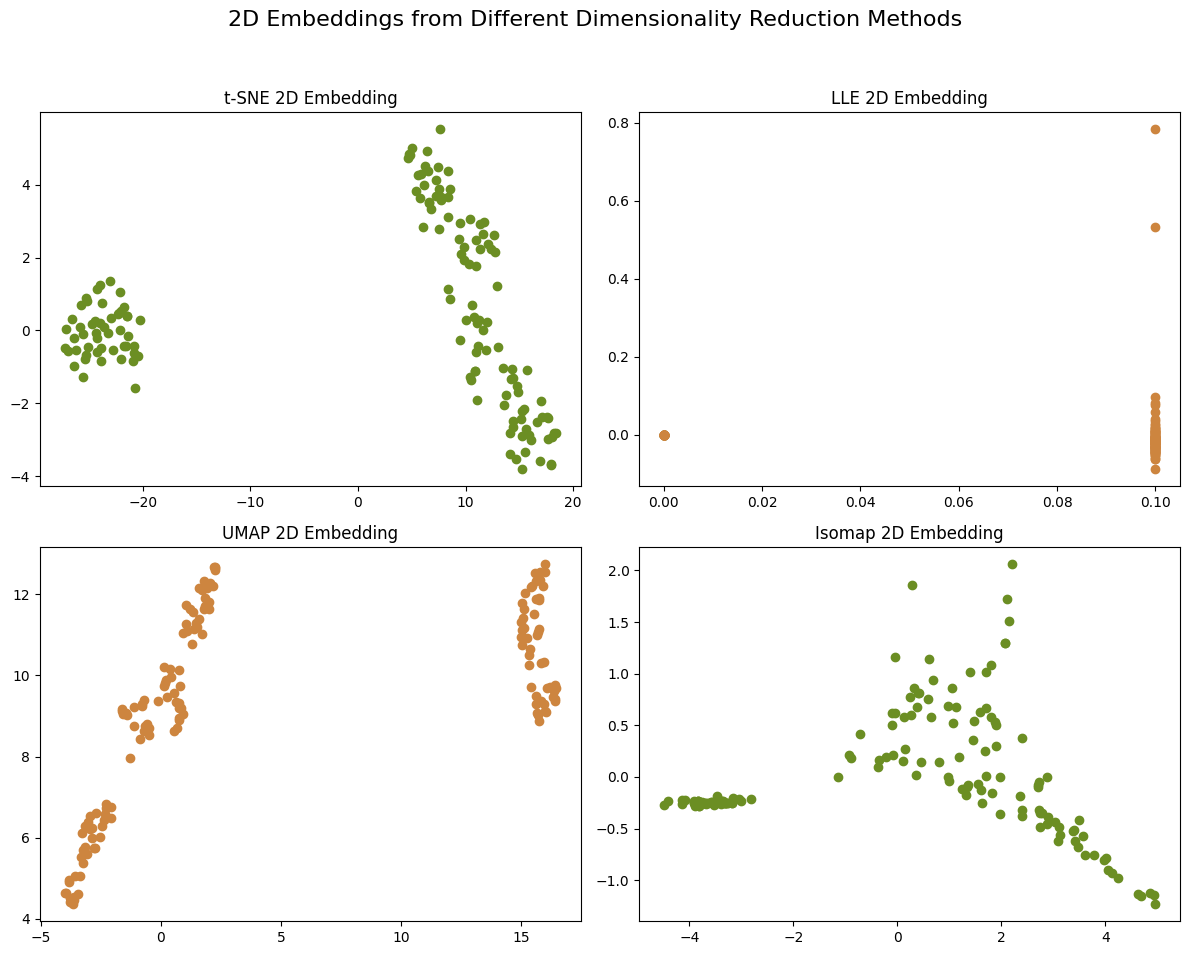

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('2D Embeddings from Different Dimensionality Reduction Methods', fontsize=16)

# t-SNE embedding
axes[0, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c='olivedrab')
axes[0, 0].set_title('t-SNE 2D Embedding')

# LLE embedding
axes[0, 1].scatter(X_lle[:, 0], X_lle[:, 1], c='peru')
axes[0, 1].set_title('LLE 2D Embedding')

# UMAP embedding
axes[1, 0].scatter(X_umap[:, 0], X_umap[:, 1], c='peru')
axes[1, 0].set_title('UMAP 2D Embedding')

# Isomap embedding
axes[1, 1].scatter(X_isomap[:, 0], X_isomap[:, 1], c='olivedrab')
axes[1, 1].set_title('Isomap 2D Embedding')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Implement a simple RBM with binary visible and hidden units.  
Train the RBM on a small dataset such as binarized MNIST or toy(?) dataset.   
Visualize the learned weights (filters) of the RBM after training.  
Use the trained RBM to reconstruct input data and compute the reconstruction error.   
How does this error change as training progresses..?
- RBM: Restricted Boltzman Machine - type of generative model that is capable of learning a probability distribution over a set of input data. Is called "restricted" because the connections between the neurons in the same layer are not allowed; each neuron in the visible layer is only connected to neurons in the hidden layer, and vice versa.

In [11]:
import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # init weights and biases
        self.weights = np.random.randn(num_visible, num_hidden) * 0.01
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250))) # clipping to prevent overflow

    def sample_hidden(self, visible_units):
        hidden_activations = np.dot(visible_units, self.weights) + self.hidden_bias
        hidden_probabilities = self.sigmoid(hidden_activations)

        return (np.random.rand(*hidden_probabilities.shape) < hidden_probabilities).astype(int)

    def sample_visible(self, hidden_units):
        visible_activations = np.dot(hidden_units, self.weights.T) + self.visible_bias
        visible_probabilities = self.sigmoid(visible_activations)

        return (np.random.rand(*visible_probabilities.shape) < visible_probabilities).astype(int)


In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist.data

subset_size = 1000
X_subset = X[:subset_size]

X_train_binary = (X_subset > 128).astype(int)

print("Shape of the original MNIST data:", X.shape)
print("Shape of the selected subset:", X_subset.shape)
print("Shape of the binarized training data:", X_train_binary.shape)

Shape of the original MNIST data: (70000, 784)
Shape of the selected subset: (1000, 784)
Shape of the binarized training data: (1000, 784)


In [18]:
class RBM(RBM): # inherited calss
    def train(self, data, learning_rate, epochs, batch_size):
        num_samples = data.shape[0]
        reconstruction_errors = []

        for epoch in range(epochs):
            np.random.shuffle(data)

            for i in range(0, num_samples, batch_size):
                batch = data[i:i + batch_size]

                # positive phase: v0 -> h0
                v0 = batch
                h0_prob = self.sigmoid(np.dot(v0, self.weights) + self.hidden_bias)
                h0_sample = (np.random.rand(*h0_prob.shape) < h0_prob).astype(int)

                # negative phase: h0 -> v1 -> h1
                v1_prob = self.sigmoid(np.dot(h0_sample, self.weights.T) + self.visible_bias)
                v1_sample = (np.random.rand(*v1_prob.shape) < v1_prob).astype(int)

                h1_prob = self.sigmoid(np.dot(v1_sample, self.weights) + self.hidden_bias)
                h1_sample = (np.random.rand(*h1_prob.shape) < h1_prob).astype(int)

                positive_gradient = np.dot(v0.T, h0_prob)
                negative_gradient = np.dot(v1_sample.T, h1_prob)

                self.weights += learning_rate * (positive_gradient - negative_gradient) / batch_size
                self.visible_bias += learning_rate * np.sum(v0 - v1_sample, axis=0) / batch_size
                self.hidden_bias += learning_rate * np.sum(h0_prob - h1_prob, axis=0) / batch_size

            h_prob = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
            v_recon_prob = self.sigmoid(np.dot(h_prob, self.weights.T) + self.visible_bias)
            error = np.mean((data - v_recon_prob)**2)
            reconstruction_errors.append(error)
            print(f"Epoch {epoch+1}/{epochs}, Reconstruction Error: {error:.4f}")


        return reconstruction_errors

input_size = X_train_binary.shape[1]
hidden_size = 128
rbm = RBM(input_size, hidden_size)

learning_rate = 0.01
epochs = 50
batch_size = 64

reconstruction_errors = rbm.train(X_train_binary, learning_rate, epochs, batch_size)


Epoch 1/50, Reconstruction Error: 0.1324
Epoch 2/50, Reconstruction Error: 0.1089
Epoch 3/50, Reconstruction Error: 0.1003
Epoch 4/50, Reconstruction Error: 0.0964
Epoch 5/50, Reconstruction Error: 0.0941
Epoch 6/50, Reconstruction Error: 0.0918
Epoch 7/50, Reconstruction Error: 0.0902
Epoch 8/50, Reconstruction Error: 0.0887
Epoch 9/50, Reconstruction Error: 0.0878
Epoch 10/50, Reconstruction Error: 0.0869
Epoch 11/50, Reconstruction Error: 0.0863
Epoch 12/50, Reconstruction Error: 0.0855
Epoch 13/50, Reconstruction Error: 0.0846
Epoch 14/50, Reconstruction Error: 0.0839
Epoch 15/50, Reconstruction Error: 0.0830
Epoch 16/50, Reconstruction Error: 0.0821
Epoch 17/50, Reconstruction Error: 0.0811
Epoch 18/50, Reconstruction Error: 0.0800
Epoch 19/50, Reconstruction Error: 0.0788
Epoch 20/50, Reconstruction Error: 0.0777
Epoch 21/50, Reconstruction Error: 0.0765
Epoch 22/50, Reconstruction Error: 0.0753
Epoch 23/50, Reconstruction Error: 0.0743
Epoch 24/50, Reconstruction Error: 0.0732
E

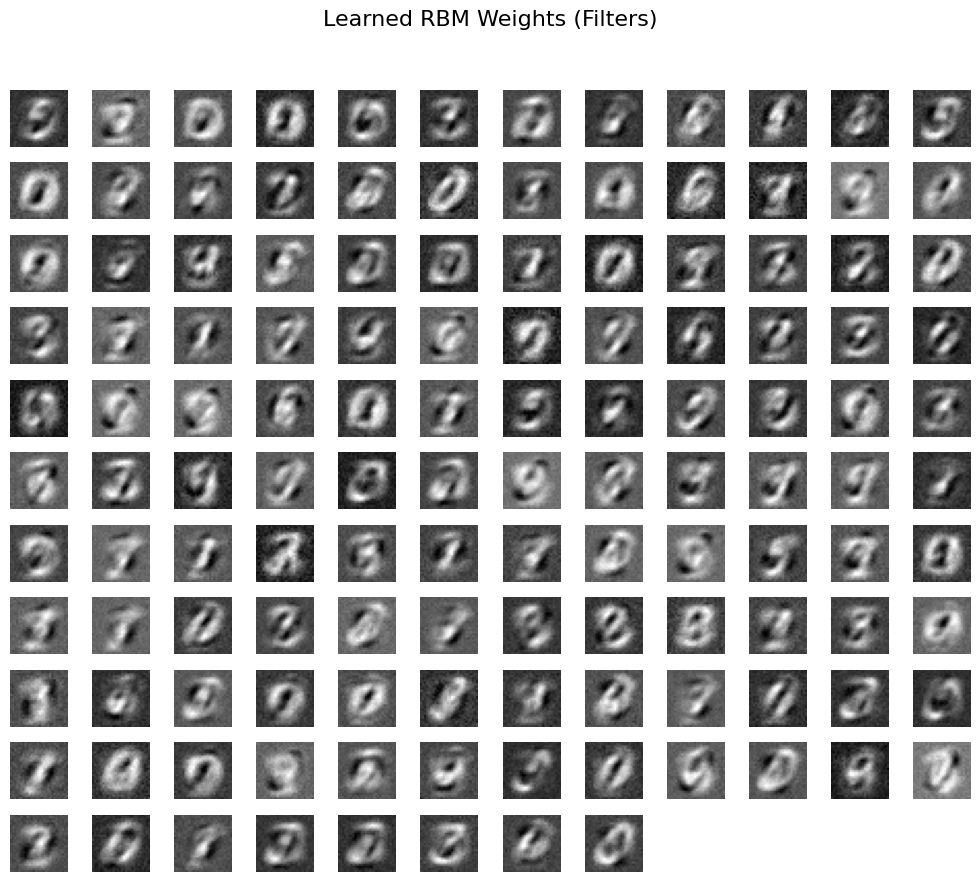

In [19]:
import matplotlib.pyplot as plt
import math

num_hidden_units = rbm.weights.shape[1]

grid_size = math.ceil(math.sqrt(num_hidden_units))
num_rows = grid_size
num_cols = grid_size

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
fig.suptitle('Learned RBM Weights (Filters)', fontsize=16)

axes = axes.flatten()

for i in range(num_hidden_units):
    weight_image = rbm.weights[:, i].reshape(28, 28)

    axes[i].imshow(weight_image, cmap='gray')
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [20]:
# select a subset of the training data
subset_to_reconstruct = X_train_binary[:10]

hidden_probabilities_subset = rbm.sigmoid(np.dot(subset_to_reconstruct, rbm.weights) + rbm.hidden_bias)

# pass the hidden unit probabilities through the rbm's visible layer to reconstruct the input data
reconstructed_data = rbm.sigmoid(np.dot(hidden_probabilities_subset, rbm.weights.T) + rbm.visible_bias)

# mse btwn og input data and recon
reconstruction_error = np.mean((subset_to_reconstruct - reconstructed_data)**2)

print(f"Reconstruction Error for the subset: {reconstruction_error:.4f}")

Reconstruction Error for the subset: 0.0613


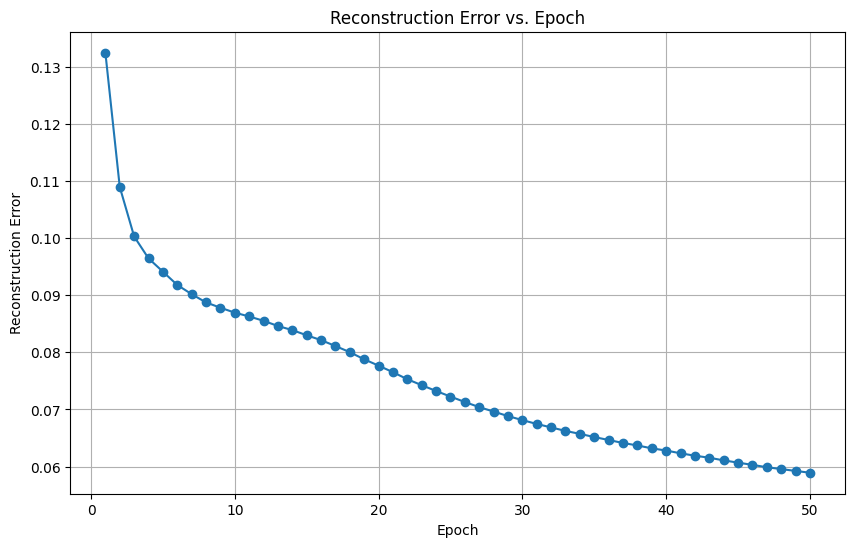

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reconstruction_errors) + 1), reconstruction_errors, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs. Epoch")
plt.grid(True)
plt.show()


-   **How does the reconstruction error change as training progresses?**
    The reconstruction error generally decreases over the training epochs, indicating that the RBM is learning to reconstruct the input data more accurately.
